# Covid Scans Classification Using Simple Methods
## Author : Abdelkader Nadir DEBBAGH (na.debbagh@gmail.com)
If you want help or the trained model, fell free to send me an e-mail.
## About
In this notebook we'll try to classify patients as having covid or not based on their scans. We'll use Convolutional Neural Netwoks (CNNs).

We'll use a pretrained model : DenseNet161

Data can be downloaded here : https://drive.google.com/file/d/1WS9WiABZM_ODhN6kSRoVSOik51mU3vI7/view

## Mounting Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading and visualizing the pretrained model

In [1]:
from torchvision import models
models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

We can see that the Densenet161 model is composed of 
An initial Conv2D/BN/ReLU/MaxPool block.
Followed by 5 denseblock-transition alterned.
A denseblock is composed of many denselayers, which have BN/ReLU/Conv2D/NB/ReLU/Conv2D

When fed a 224*224 input, the feature selection block outputs a flattened 2208 sized vector, which is then fed into a fully connected classifier.

DenseNet was initially trained on 1000 classes, in our case we only have 2 so we'll change the classifier part accordingly.

In [2]:
import PIL
import os

In [3]:
# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

## Importing the Data (DataLoaders)

Here we declare dataloaders to load our data. We also split our data into 0.3 Testing and 0.7 Training.

We then split the resulting training data ito 0.1 Validation and 0.9 Training.

In [6]:
# Data directory's path
data_dir = '/content/drive/MyDrive/Colab Notebooks/covid'
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 25
# Validation set size
valid_size= 0.1
test_size = 0.3
# Defining transforms

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Loading the dataset with ImageFolder

data = datasets.ImageFolder(data_dir, transform=train_transforms)

#Validation portion 
# Splitting the data into training/testing
num_data = len(data)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

# Splitting the training data into training/validation
num_train = len(train_idx)
np.random.shuffle(train_idx)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = train_idx[split:], train_idx[:split]

# define samplers for obtaining training, testing and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)


# Defining the dataloaders

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                           sampler=train_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=test_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)

print("Training size : ",len(train_loader))
print("Validation size : ",len(valid_loader))
print("Testing size : ",len(test_loader))
print(data.class_to_idx)


Training size :  63
Validation size :  7
Testing size :  30
{'COVID': 0, 'non-COVID': 1}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating the model and changing the Classifier Part

In [7]:
model = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


We define our classifier part as being a : (2208 -> 512 -> 128 -> 2) fully connected connected neural network. So we have 2 hidden layers with sizes 512 and 128, each followed by a ReLU activation function and no Dropout.

In [8]:
#Freezing the parameters
for param in model.parameters():
    param.requires_grad = False

class Network(nn.Module):
    def __init__(self,n_hidden1=512,n_hidden2=128):
        super().__init__()

        self.fc1=nn.Linear(2208,n_hidden1)
        self.relu1=nn.ReLU()
        self.fc2=nn.Linear(n_hidden1,n_hidden2)
        self.relu2=nn.ReLU()
        self.output=nn.Linear(n_hidden2,2)
    
    def forward(self,x):
        x=self.relu1(self.fc1(x))
        x=self.relu2(self.fc2(x))
        x=self.output(x)
        return x

model.classifier=Network()

## Model saving functions

Functions used to save/load models. For example we'll need to save the model when there is a decrease in validation loss.

In [9]:
def save_model(model,minimum_loss,filename):
    st=model.state_dict()
    torch.save({"minloss":minimum_loss,"state":st},filename)

def load_model(filename):
    return torch.load(filename)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

'\nmodel.load_state_dict(load_model("/content/min_densenet161_0.6997023820877075.pt"))\nmodel=model.cuda()\noptimizer=optim.Adam(model.classifier.parameters(),lr=0.005)\nmodel\n\n'

## The training function

We'll define here a general purpose function that will allow us to parameter our training.

The function allows us to :
- Choose "Training on CUDA" or "Training on CPU" using the `TRAIN_CUDA` parameter
- Choose the optimizer type "SGD" or "ADAM".
- Indicate how many training epochs we want : `n_epochs`.
- Specify  at what epoch to freeze the feature extraction weights (At first we unfreeze the feature selection part of the network and train all the network's weights, then after `N_EPOCHS_TO_FREEZE`, we freeze the feature selection part's weights and only train the classifier part, this allows us to do a "fine tuning" on the feature selection weights which yields better results)
- Specify whether we want to initially freeze or not the weights `freeze`, (Fo 
- Train further a previously trained network by setting `cont=True`, because by default we'll initialize weights randomly and start all over again.

Note that we are using a Cross Entropy Loss and the learning rate is scheduled using a Decrease on Plateau strategy, this allows us to adjust the learning rate when the loss is on a plateau.

This function will run the training for n_epochs and will print the validation after each epoch in addition to graphs showing the evolution over the epochs of : the Training/Validation Loss, the Validation Accuracy, and the learning rate. Each time we get a better-performing model, we save it in a `.pt` file with the corresponding validation accuracy in its name.

In [10]:
import time
def trainCEL(model,n_epochs,train_loader,valid_loader,TRAIN_CUDA = False, learning_rate=0.01,opt="SGD",cont=False,modelPath=None,freeze=True,N_EPOCHS_TO_FREEZE=30):
  if TRAIN_CUDA:
    model=model.cuda()

  minimum_loss=np.inf
  if(cont):
    chpt=load_model(modelPath)
    model.load_state_dict(chpt["state"])
    minimum_loss=chpt["minloss"]
  
  #Freeze logic
  parameters_to_train = model.classifier.parameters()
  if freeze:
    for param in model.parameters():
      param.requires_grad = False
    for param in model.classifier.parameters():
      param.requires_grad = True
  else:
    for param in model.parameters():
      param.requires_grad = True
    parameters_to_train=model.parameters()
      
      
      
  criterion = nn.CrossEntropyLoss()
  if opt=="Adam":
    optimizer=optim.Adam(parameters_to_train,lr=learning_rate)
  elif opt=="SGD":
    optimizer=optim.SGD(parameters_to_train,lr=learning_rate,momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  model.train()
  plot_training_loss=[]
  plot_validation_loss=[]
  plot_accuracy=[]
  plot_lr=[]
  startTime=time.time()
  for e in range(n_epochs):
    if not freeze:
      if((e+1)==N_EPOCHS_TO_FREEZE):
        for param in model.parameters():
          param.requires_grad = False
        for param in model.classifier.parameters():
          param.requires_grad = True
        if opt=="Adam":
          optimizer=optim.Adam(model.classifier.parameters(),lr=learning_rate)
        elif opt=="SGD":
          optimizer=optim.SGD(model.classifier.parameters(),lr=learning_rate,momentum=0.9)
      
      
    running_loss=0
    step=0
    startEpoch=time.time()
    for images,labels in train_loader:
      #move variables to GPU
      if TRAIN_CUDA:
        images,labels = images.cuda(),labels.cuda()

      optimizer.zero_grad()
      #forward
      output=model(images)
      #calculate loss
      loss=criterion(output,labels)
      #backpropagate
      loss.backward()
      #update weights
      optimizer.step()
      #accumulate loss
      running_loss+=loss.item()
      step+=1
      if(step%10 ==0):
        print(f"Epoch {e+1} , Batch {step}/{len(train_loader)} Loss:{loss} Running time Epoch: {time.time()-startEpoch:.3f} s, Running Time: {time.time()-startTime:.3f} s")

    running_loss/=len(train_loader)
    #add to the list to plot
    plot_training_loss.append(running_loss)
    
    #Validation part 
    validation_loss=0
    accuracy=0

    model.eval()
    with torch.no_grad():
        for images,labels in valid_loader:
          #move variables to GPU
          if TRAIN_CUDA:
            images,labels = images.cuda(),labels.cuda()

          #forward
          output=model(images)
          #calculate loss
          loss=criterion(output,labels)

          #calculate validation loss 
          validation_loss+=loss.item()
          #calculate accuracy
          ps=F.softmax(output,dim=1)
          top_p,top_c= ps.topk(1,dim=1)
          equals= labels == top_c.view(*labels.shape)
          accuracy+= equals.type(torch.FloatTensor).mean()


        validation_loss/=len(valid_loader)
        accuracy/=len(valid_loader)
        #add to the list to plot
        plot_validation_loss.append(validation_loss)
        
        scheduler.step(validation_loss)
        
        plot_lr.append(get_lr(optimizer))
        
        plot_accuracy.append(accuracy)
        
        better=False
        if validation_loss<minimum_loss:
          minimum_loss=validation_loss
          save_model(model,minimum_loss,"net16_nodropout_unfrozen_{0:.3f}.pt".format(accuracy))
          better=True

    model.train()
    print(f"======>Epoch {e+1} Finished , TLoss:{running_loss} VLoss :{validation_loss} Accuracy : {accuracy} Better : {better} Time taken: {time.time() -startEpoch}")
    ax=plt.figure()
    t=ax.add_subplot(3,1,1)
    t.plot(plot_validation_loss,label="Validation loss")
    t.plot(plot_training_loss,label="Training loss")
    plt.legend()

    v=ax.add_subplot(3,1,2)
    v.plot(plot_accuracy,label="Accuracy")
    plt.legend()
    
    l=ax.add_subplot(3,1,3)
    l.plot(plot_lr,label="Learning Rate")
    
    plt.legend()
    plt.show()

In our case:
- We train our model only for 10 epochs on GPU (Google Colab).
- We choose an initial learning rate of 0.01 and an SGD (Stochastic Gradient Descent) optimizer.
- We do not freeze the feature selection weights and train all of the network to do "fine tuning".

The overall training time was 485 seconds which is about 8 minutes. And the best validation accuracy we got was `99.42%` on the 6th epoch.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 , Batch 10/63 Loss:0.677693247795105 Running time Epoch: 22.307 s, Running Time: 22.307 s
Epoch 1 , Batch 20/63 Loss:0.5932630896568298 Running time Epoch: 37.198 s, Running Time: 37.198 s
Epoch 1 , Batch 30/63 Loss:0.36583542823791504 Running time Epoch: 58.294 s, Running Time: 58.294 s
Epoch 1 , Batch 40/63 Loss:0.17478348314762115 Running time Epoch: 73.219 s, Running Time: 73.219 s
Epoch 1 , Batch 50/63 Loss:0.48261672258377075 Running time Epoch: 92.095 s, Running Time: 92.095 s
Epoch 1 , Batch 60/63 Loss:0.4372609257698059 Running time Epoch: 106.962 s, Running Time: 106.962 s
======>Epoch 1 Finished , TLoss:0.43349826040249023 VLoss :0.6694201273577554 Accuracy : 0.6765217185020447 Better : True Time taken: 128.60011506080627


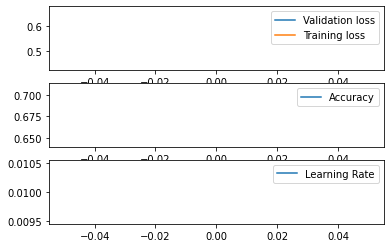

Epoch 2 , Batch 10/63 Loss:0.23377078771591187 Running time Epoch: 6.454 s, Running Time: 135.451 s
Epoch 2 , Batch 20/63 Loss:0.15043824911117554 Running time Epoch: 12.375 s, Running Time: 141.372 s
Epoch 2 , Batch 30/63 Loss:0.03469139710068703 Running time Epoch: 18.373 s, Running Time: 147.370 s
Epoch 2 , Batch 40/63 Loss:0.11419285088777542 Running time Epoch: 24.439 s, Running Time: 153.435 s
Epoch 2 , Batch 50/63 Loss:0.6007479429244995 Running time Epoch: 30.476 s, Running Time: 159.473 s
Epoch 2 , Batch 60/63 Loss:0.18845157325267792 Running time Epoch: 36.438 s, Running Time: 165.435 s
======>Epoch 2 Finished , TLoss:0.18423069377858486 VLoss :0.17658340292317526 Accuracy : 0.9470807313919067 Better : True Time taken: 40.24112296104431


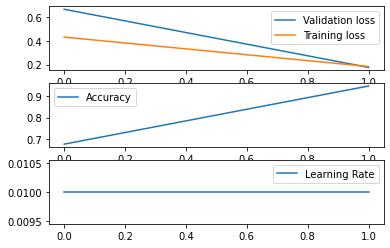

Epoch 3 , Batch 10/63 Loss:0.016053108498454094 Running time Epoch: 6.660 s, Running Time: 176.224 s
Epoch 3 , Batch 20/63 Loss:0.0020682939793914557 Running time Epoch: 12.557 s, Running Time: 182.121 s
Epoch 3 , Batch 30/63 Loss:0.2365005612373352 Running time Epoch: 18.434 s, Running Time: 187.998 s
Epoch 3 , Batch 40/63 Loss:0.14712589979171753 Running time Epoch: 24.294 s, Running Time: 193.858 s
Epoch 3 , Batch 50/63 Loss:0.03801381215453148 Running time Epoch: 30.137 s, Running Time: 199.701 s
Epoch 3 , Batch 60/63 Loss:0.11980081349611282 Running time Epoch: 35.968 s, Running Time: 205.532 s
======>Epoch 3 Finished , TLoss:0.09224739033610575 VLoss :0.09467921086720057 Accuracy : 0.9590062499046326 Better : True Time taken: 39.81969094276428


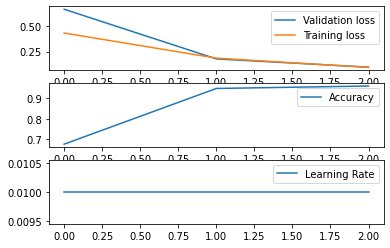

Epoch 4 , Batch 10/63 Loss:0.12951678037643433 Running time Epoch: 6.620 s, Running Time: 216.309 s
Epoch 4 , Batch 20/63 Loss:0.017265092581510544 Running time Epoch: 12.491 s, Running Time: 222.180 s
Epoch 4 , Batch 30/63 Loss:0.029149863868951797 Running time Epoch: 18.359 s, Running Time: 228.049 s
Epoch 4 , Batch 40/63 Loss:0.008474256843328476 Running time Epoch: 24.245 s, Running Time: 233.934 s
Epoch 4 , Batch 50/63 Loss:0.01676322892308235 Running time Epoch: 30.151 s, Running Time: 239.840 s
Epoch 4 , Batch 60/63 Loss:0.028026608750224113 Running time Epoch: 36.045 s, Running Time: 245.735 s
======>Epoch 4 Finished , TLoss:0.06626499483420972 VLoss :0.23088964646948235 Accuracy : 0.92521733045578 Better : False Time taken: 39.56277680397034


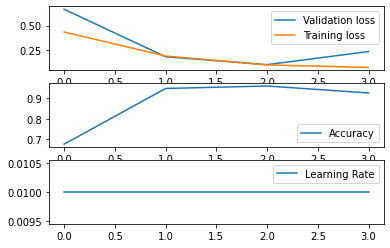

Epoch 5 , Batch 10/63 Loss:0.05839698389172554 Running time Epoch: 6.635 s, Running Time: 256.190 s
Epoch 5 , Batch 20/63 Loss:0.03189642354846001 Running time Epoch: 12.530 s, Running Time: 262.085 s
Epoch 5 , Batch 30/63 Loss:0.10081829130649567 Running time Epoch: 18.446 s, Running Time: 268.001 s
Epoch 5 , Batch 40/63 Loss:0.0076838149689137936 Running time Epoch: 24.378 s, Running Time: 273.933 s
Epoch 5 , Batch 50/63 Loss:0.007068551145493984 Running time Epoch: 30.286 s, Running Time: 279.841 s
Epoch 5 , Batch 60/63 Loss:0.013506424613296986 Running time Epoch: 36.187 s, Running Time: 285.742 s
======>Epoch 5 Finished , TLoss:0.053280773454360546 VLoss :1.6823957136699133 Accuracy : 0.5982608795166016 Better : False Time taken: 39.80260109901428


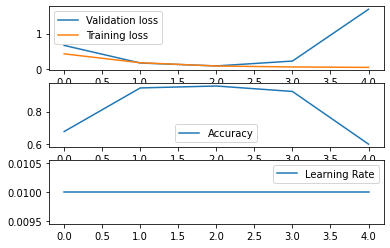

Epoch 6 , Batch 10/63 Loss:0.03843790665268898 Running time Epoch: 6.646 s, Running Time: 296.322 s
Epoch 6 , Batch 20/63 Loss:0.009121653623878956 Running time Epoch: 12.528 s, Running Time: 302.205 s
Epoch 6 , Batch 30/63 Loss:0.06277298182249069 Running time Epoch: 18.404 s, Running Time: 308.080 s
Epoch 6 , Batch 40/63 Loss:0.010973475873470306 Running time Epoch: 24.280 s, Running Time: 313.957 s
Epoch 6 , Batch 50/63 Loss:0.007309964392334223 Running time Epoch: 30.151 s, Running Time: 319.827 s
Epoch 6 , Batch 60/63 Loss:0.0066801924258470535 Running time Epoch: 36.013 s, Running Time: 325.690 s
======>Epoch 6 Finished , TLoss:0.050852976218309434 VLoss :0.03140777515779648 Accuracy : 0.9942857027053833 Better : True Time taken: 39.759865283966064


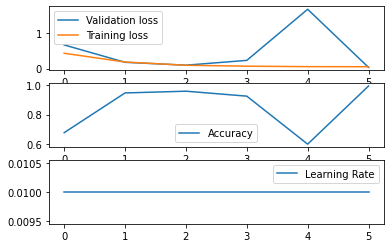

Epoch 7 , Batch 10/63 Loss:0.005992503836750984 Running time Epoch: 6.860 s, Running Time: 336.605 s
Epoch 7 , Batch 20/63 Loss:0.000693910988047719 Running time Epoch: 12.733 s, Running Time: 342.478 s
Epoch 7 , Batch 30/63 Loss:0.007469224743545055 Running time Epoch: 18.604 s, Running Time: 348.348 s
Epoch 7 , Batch 40/63 Loss:0.0035897577181458473 Running time Epoch: 24.481 s, Running Time: 354.226 s
Epoch 7 , Batch 50/63 Loss:0.009684274904429913 Running time Epoch: 30.375 s, Running Time: 360.119 s
Epoch 7 , Batch 60/63 Loss:0.0027374718338251114 Running time Epoch: 36.263 s, Running Time: 366.007 s
======>Epoch 7 Finished , TLoss:0.0071322763664832724 VLoss :0.014205936961973618 Accuracy : 0.9880746006965637 Better : True Time taken: 40.053499698638916


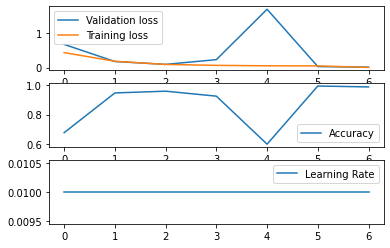

Epoch 8 , Batch 10/63 Loss:0.009353144094347954 Running time Epoch: 6.583 s, Running Time: 376.711 s
Epoch 8 , Batch 20/63 Loss:0.053588591516017914 Running time Epoch: 12.486 s, Running Time: 382.614 s
Epoch 8 , Batch 30/63 Loss:0.010913800448179245 Running time Epoch: 18.386 s, Running Time: 388.513 s
Epoch 8 , Batch 40/63 Loss:0.1397256702184677 Running time Epoch: 24.273 s, Running Time: 394.400 s
Epoch 8 , Batch 50/63 Loss:0.008201428689062595 Running time Epoch: 30.175 s, Running Time: 400.302 s
Epoch 8 , Batch 60/63 Loss:0.001716751023195684 Running time Epoch: 36.053 s, Running Time: 406.180 s
======>Epoch 8 Finished , TLoss:0.045508676153119834 VLoss :0.026810551611041383 Accuracy : 0.9885714650154114 Better : False Time taken: 39.5801203250885


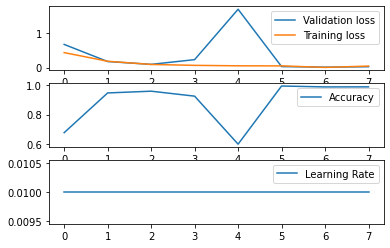

Epoch 9 , Batch 10/63 Loss:0.0003970692923758179 Running time Epoch: 6.558 s, Running Time: 416.569 s
Epoch 9 , Batch 20/63 Loss:0.0022830322850495577 Running time Epoch: 12.449 s, Running Time: 422.461 s
Epoch 9 , Batch 30/63 Loss:0.00095806346507743 Running time Epoch: 18.335 s, Running Time: 428.346 s
Epoch 9 , Batch 40/63 Loss:0.007407666649669409 Running time Epoch: 24.228 s, Running Time: 434.239 s
Epoch 9 , Batch 50/63 Loss:0.00015485560288652778 Running time Epoch: 30.121 s, Running Time: 440.132 s
Epoch 9 , Batch 60/63 Loss:0.011929439380764961 Running time Epoch: 35.989 s, Running Time: 446.000 s
======>Epoch 9 Finished , TLoss:0.009473317054572463 VLoss :0.023846166758240934 Accuracy : 0.9880746006965637 Better : False Time taken: 39.564308404922485


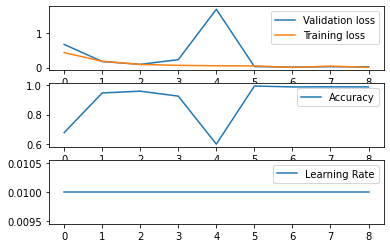

Epoch 10 , Batch 10/63 Loss:0.0006554028950631618 Running time Epoch: 6.563 s, Running Time: 456.439 s
Epoch 10 , Batch 20/63 Loss:0.03583657369017601 Running time Epoch: 12.446 s, Running Time: 462.322 s
Epoch 10 , Batch 30/63 Loss:0.0023757843300700188 Running time Epoch: 18.340 s, Running Time: 468.215 s
Epoch 10 , Batch 40/63 Loss:0.0012464002938941121 Running time Epoch: 24.238 s, Running Time: 474.113 s
Epoch 10 , Batch 50/63 Loss:0.0049682254903018475 Running time Epoch: 30.136 s, Running Time: 480.012 s
Epoch 10 , Batch 60/63 Loss:0.002529553137719631 Running time Epoch: 36.013 s, Running Time: 485.888 s
======>Epoch 10 Finished , TLoss:0.02105504147131421 VLoss :0.103869140414255 Accuracy : 0.9761490821838379 Better : False Time taken: 39.54259252548218


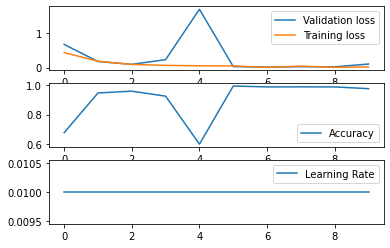

In [11]:
trainCEL(model,10,train_loader,valid_loader,TRAIN_CUDA= True, learning_rate=0.01,opt="SGD",freeze=False)

## Testing the Model
In this part, we import the best performing model and test it on our testing data. Recall that we didn't use our testing data at all, and based our training only on the training and validation data.

In [12]:
model=model.cuda()
model.eval()
chpt=load_model("/content/net16_nodropout_unfrozen_0.994.pt")
criterion=nn.CrossEntropyLoss()
model.load_state_dict(chpt["state"])
testing_loss=0
testing_accuracy=0
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.cuda(),labels.cuda()

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing Loss : 0.06685063804034144 Testing_accuracy : 0.9809120893478394


We can see that we were able to get a 98% accuracy using a CNN, vs. 90% and 79% for Random Forest and Logistic Regression.

We can see here the importance of considering spatial correlations in the data. And hence, the power of CNNs in classifying images.

We also see how useful pretrained models are, in the sense that they provide us with a very well tuned and powerful feature extraction part, that already learned to extract relevant features from images. All we need to do then is to freeze feature extraction weights and train a custom classifier part.